# Image Segmentation by Supervised Learning

## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## hyper-parameters

In [3]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 400
size_minibatch  = 50
learning_rate   = 0.1
weight_decay    = 0.01

## custom data loader for the PyTorch framework

In [4]:
class dataset(Dataset):
    
    def __init__(self, image, label, transform=0):
        
        self.image  = image
        self.label  = label 
        self.transform = transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)

        image   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
        label   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)

        if self.transform == 1:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,2])
            label = torch.flip(label, [0,2])
            
            #
            # ==================================================

        if self.transform == 2:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,1])
            label = torch.flip(label, [0,1])
            
            #
            # ==================================================
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [5]:
dataset_train_transform = dataset(x_train, y_train, transform=1)
dataset_train_transform_ud = dataset(x_train, y_train, transform=2)
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train_transform_ud  = DataLoader(dataset_train_transform_ud, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 64, 64])
shape of the label in the training dataset: torch.Size([1, 64, 64])


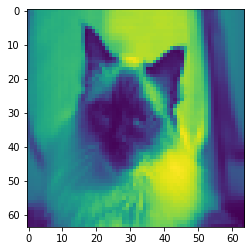

*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 64, 64])
shape of the label in the testing dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the training transform dataset: torch.Size([1, 64, 64])
shape of the label in the training transform dataset: torch.Size([1, 64, 64])


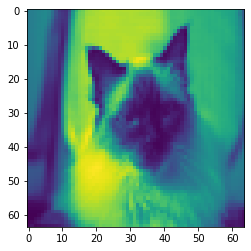

*******************************************************************


In [6]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
(image_train_transform, label_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
plt.imshow(image_train[0], interpolation='nearest')
plt.show()
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')
print('shape of the image in the training transform dataset:', image_train_transform.shape)
print('shape of the label in the training transform dataset:', label_train_transform.shape)
plt.imshow(image_train_transform[0], interpolation='nearest')
plt.show()
print('*******************************************************************')

## class for the neural network 

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        
        self.e_layers = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.BatchNorm2d(16),
												nn.ReLU(),
                        # nn.MaxPool2d(2,2),
                        
                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.BatchNorm2d(32),
												nn.ReLU(),
                        # nn.MaxPool2d(2,2),
                        

                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(64),
												nn.ReLU(),
                        # nn.MaxPool2d(2,2),

                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(128),
												nn.ReLU(),
                        nn.MaxPool2d(2,2),

                        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(256),
												nn.ReLU(),
                        nn.MaxPool2d(2,2),

        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------

        
        self.d_layers = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(128),
												nn.ReLU(),
                        
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(64),
												nn.ReLU(),


                        # nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(32),
												nn.ReLU(),

                        # nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(16),
												nn.ReLU(),
                        
                        # nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layers, 
                        self.d_layers,
        )

        self.initialize_weight()

    def forward(self,x):
        out = self.network(x)
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self): 
        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):
                m.reset_parameters()
                # xavier(m.weight.data)
                # xavier(m.bias.data)

            elif isinstance(m, nn.BatchNorm2d):
                m.reset_parameters()
                # xavier(m.weight.data)
                # xavier(m.bias.data)

            elif isinstance(m, nn.Linear):
                m.reset_parameters()

In [8]:
# class Network(nn.Module): 

# 	def __init__(self, in_channel=1, out_channel=1, dim_feature=8, dim_code=8, threshold_ReLU=0.01):
        
# 		super(Network, self).__init__()

# 		self.in_channel 	= in_channel
# 		self.out_channel	= out_channel
# 		self.dim_feature	= dim_feature
		
# 		self.conv_encode1	= nn.Conv2d(in_channel , dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True)
# 		self.conv_encode2	= nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)
# 		self.conv_middle	= nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True)
# 		self.conv_decode2 	= nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True)
# 		self.conv_decode1 	= nn.Conv2d(dim_feature * 2, dim_feature * 1,	kernel_size=3, stride=1, padding=1, bias=True)
# 		self.conv_out 		= nn.Conv2d(dim_feature * 1, out_channel,	kernel_size=1, stride=1, padding=0, bias=True)

# 		self.ebn1			= nn.BatchNorm2d(dim_feature * 1)
# 		self.ebn2			= nn.BatchNorm2d(dim_feature * 2)
# 		self.mbn		 	= nn.BatchNorm2d(dim_feature * 4)
# 		self.dbn2			= nn.BatchNorm2d(dim_feature * 2)
# 		self.dbn1			= nn.BatchNorm2d(dim_feature * 1)

# 		self.activation		= nn.ReLU(inplace=True)
# 		self.activation_out	= nn.Sigmoid()

# 		# *********************************************************************
# 		# forward propagation
# 		# *********************************************************************
# 	def forward(self, x):

# 		x1  = self.conv_encode1(x)
# 		eb1 = self.ebn1(x1)
# 		e1  = self.activation(eb1)

# 		x2  = self.conv_encode2(e1)
# 		eb2 = self.ebn2(x2)
# 		e2  = self.activation(eb2)
		
# 		m   = self.conv_middle(e2)
# 		mb  = self.mbn(m)
# 		c   = self.activation(mb)

# 		y2  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(c)
# 		y2  = self.conv_decode2(y2) 
# 		db2 = self.dbn2(y2)
# 		d2  = self.activation(db2)
		
# 		y1  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(d2)
# 		y1  = self.conv_decode1(y1) 
# 		db1 = self.dbn1(y1)
# 		d1  = self.activation(db1)
		
# 		y1  = self.conv_out(d1)
# 		y = self.activation_out(y1)

# 		return y


## build network

In [9]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [10]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [11]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    mse = nn.MSELoss()
    loss = mse(label, prediction)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [12]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [13]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [14]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [15]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [16]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']
    print(accuracy_mean_test[i])

  0%|▏                                                                                 | 1/400 [00:05<38:23,  5.77s/it]

0.01707634917425284


  0%|▍                                                                                 | 2/400 [00:09<29:36,  4.46s/it]

0.10590263735188273


  1%|▌                                                                                 | 3/400 [00:12<26:45,  4.05s/it]

51.46566479354025


  1%|▊                                                                                 | 4/400 [00:16<25:25,  3.85s/it]

59.18623499833762


  1%|█                                                                                 | 5/400 [00:19<24:37,  3.74s/it]

59.02349687459084


  2%|█▏                                                                                | 6/400 [00:23<24:07,  3.67s/it]

61.98734310603294


  2%|█▍                                                                                | 7/400 [00:27<23:49,  3.64s/it]

60.59115067131712


  2%|█▋                                                                                | 8/400 [00:30<23:34,  3.61s/it]

59.46583879840751


  2%|█▊                                                                                | 9/400 [00:34<23:23,  3.59s/it]

50.10933283379089


  2%|██                                                                               | 10/400 [00:37<23:15,  3.58s/it]

62.601776908437586


  3%|██▏                                                                              | 11/400 [00:41<23:07,  3.57s/it]

61.12468981615858


  3%|██▍                                                                              | 12/400 [00:44<23:01,  3.56s/it]

64.3996149383195


  3%|██▋                                                                              | 13/400 [00:48<22:56,  3.56s/it]

59.55914376104451


  4%|██▊                                                                              | 14/400 [00:51<22:51,  3.55s/it]

64.56455986195525


  4%|███                                                                              | 15/400 [00:55<22:47,  3.55s/it]

57.91434899398193


  4%|███▏                                                                             | 16/400 [00:59<22:43,  3.55s/it]

57.07762943403475


  4%|███▍                                                                             | 17/400 [01:02<22:39,  3.55s/it]

63.952734273081205


  4%|███▋                                                                             | 18/400 [01:06<22:36,  3.55s/it]

55.66595104713235


  5%|███▊                                                                             | 19/400 [01:09<22:34,  3.55s/it]

64.73973409103814


  5%|████                                                                             | 20/400 [01:13<22:30,  3.55s/it]

65.22475589734839


  5%|████▎                                                                            | 21/400 [01:16<22:27,  3.56s/it]

61.66694003366276


  6%|████▍                                                                            | 22/400 [01:20<22:23,  3.56s/it]

60.289715966633366


  6%|████▋                                                                            | 23/400 [01:23<22:20,  3.56s/it]

64.79793490699697


  6%|████▊                                                                            | 24/400 [01:27<22:17,  3.56s/it]

65.82139224007784


  6%|█████                                                                            | 25/400 [01:30<22:13,  3.56s/it]

65.81058069038512


  6%|█████▎                                                                           | 26/400 [01:34<22:10,  3.56s/it]

62.407999760244834


  7%|█████▍                                                                           | 27/400 [01:38<22:06,  3.56s/it]

62.762164528315125


  7%|█████▋                                                                           | 28/400 [01:41<22:03,  3.56s/it]

65.93326146798218


  7%|█████▊                                                                           | 29/400 [01:45<21:59,  3.56s/it]

58.90207120290291


  8%|██████                                                                           | 30/400 [01:48<21:56,  3.56s/it]

63.362576518620315


  8%|██████▎                                                                          | 31/400 [01:52<21:52,  3.56s/it]

38.60359765412791


  8%|██████▍                                                                          | 32/400 [01:55<21:49,  3.56s/it]

30.364833598437702


  8%|██████▋                                                                          | 33/400 [01:59<21:45,  3.56s/it]

62.56508572855966


  8%|██████▉                                                                          | 34/400 [02:03<21:42,  3.56s/it]

63.7886713679886


  9%|███████                                                                          | 35/400 [02:06<21:39,  3.56s/it]

62.941663699281804


  9%|███████▎                                                                         | 36/400 [02:10<21:37,  3.56s/it]

64.38140168222222


  9%|███████▍                                                                         | 37/400 [02:13<21:34,  3.57s/it]

62.402017898508106


 10%|███████▋                                                                         | 38/400 [02:17<21:30,  3.57s/it]

58.04942846632473


 10%|███████▉                                                                         | 39/400 [02:20<21:27,  3.57s/it]

41.02092828008712


 10%|████████                                                                         | 40/400 [02:24<21:23,  3.57s/it]

3.8982037459995054


 10%|████████▎                                                                        | 41/400 [02:27<21:20,  3.57s/it]

63.48161535030803


 10%|████████▌                                                                        | 42/400 [02:31<21:16,  3.57s/it]

55.213220339326014


 11%|████████▋                                                                        | 43/400 [02:35<21:13,  3.57s/it]

29.05270642440641


 11%|████████▉                                                                        | 44/400 [02:38<21:09,  3.57s/it]

60.5269615683824


 11%|█████████                                                                        | 45/400 [02:42<21:05,  3.57s/it]

53.32271493304806


 12%|█████████▎                                                                       | 46/400 [02:45<21:02,  3.57s/it]

58.00437764955957


 12%|█████████▌                                                                       | 47/400 [02:49<20:58,  3.57s/it]

47.55253852002632


 12%|█████████▋                                                                       | 48/400 [02:52<20:55,  3.57s/it]

62.44594928458004


 12%|█████████▉                                                                       | 49/400 [02:56<20:53,  3.57s/it]

61.97442343563618


 12%|██████████▏                                                                      | 50/400 [03:00<20:49,  3.57s/it]

56.96634425465498


 13%|██████████▎                                                                      | 51/400 [03:03<20:46,  3.57s/it]

10.301358339232587


 13%|██████████▌                                                                      | 52/400 [03:07<20:42,  3.57s/it]

40.59125335992389


 13%|██████████▋                                                                      | 53/400 [03:10<20:39,  3.57s/it]

59.99411312213195


 14%|██████████▉                                                                      | 54/400 [03:14<20:36,  3.57s/it]

61.6435409101729


 14%|███████████▏                                                                     | 55/400 [03:17<20:32,  3.57s/it]

55.312216010333486


 14%|███████████▎                                                                     | 56/400 [03:21<20:29,  3.57s/it]

52.38815447618714


 14%|███████████▌                                                                     | 57/400 [03:25<20:27,  3.58s/it]

27.350540640957114


 14%|███████████▋                                                                     | 58/400 [03:28<20:25,  3.58s/it]

60.497074340843966


 15%|███████████▉                                                                     | 59/400 [03:32<20:25,  3.59s/it]

57.3883182110598


 15%|████████████▏                                                                    | 60/400 [03:35<20:20,  3.59s/it]

45.88934744860295


 15%|████████████▎                                                                    | 61/400 [03:39<20:14,  3.58s/it]

62.75230596680152


 16%|████████████▌                                                                    | 62/400 [03:43<20:09,  3.58s/it]

57.5045363581324


 16%|████████████▊                                                                    | 63/400 [03:46<20:04,  3.58s/it]

58.75033496724325


 16%|████████████▉                                                                    | 64/400 [03:50<20:00,  3.57s/it]

58.54684781065809


 16%|█████████████▏                                                                   | 65/400 [03:53<19:55,  3.57s/it]

31.428742901270816


 16%|█████████████▎                                                                   | 66/400 [03:57<19:51,  3.57s/it]

52.095872734877446


 17%|█████████████▌                                                                   | 67/400 [04:00<19:51,  3.58s/it]

54.894046796213324


 17%|█████████████▊                                                                   | 68/400 [04:04<19:50,  3.59s/it]

48.37859688968976


 17%|█████████████▉                                                                   | 69/400 [04:08<19:46,  3.58s/it]

49.24850315801362


 18%|██████████████▏                                                                  | 70/400 [04:11<19:43,  3.59s/it]

55.15426620189611


 18%|██████████████▍                                                                  | 71/400 [04:15<19:38,  3.58s/it]

24.88565949895976


 18%|██████████████▌                                                                  | 72/400 [04:18<19:34,  3.58s/it]

59.86754233290981


 18%|██████████████▊                                                                  | 73/400 [04:22<19:31,  3.58s/it]

58.62259335879558


 18%|██████████████▉                                                                  | 74/400 [04:26<19:27,  3.58s/it]

63.55880706817908


 19%|███████████████▏                                                                 | 75/400 [04:29<19:23,  3.58s/it]

54.94061301910044


 19%|███████████████▍                                                                 | 76/400 [04:33<19:20,  3.58s/it]

44.69564572385664


 19%|███████████████▌                                                                 | 77/400 [04:36<19:16,  3.58s/it]

65.1817476907883


 20%|███████████████▊                                                                 | 78/400 [04:40<19:13,  3.58s/it]

42.43186449104994


 20%|███████████████▉                                                                 | 79/400 [04:43<19:09,  3.58s/it]

52.64135366278697


 20%|████████████████▏                                                                | 80/400 [04:47<19:05,  3.58s/it]

63.41649745363473


 20%|████████████████▍                                                                | 81/400 [04:51<19:02,  3.58s/it]

65.3013637267783


 20%|████████████████▌                                                                | 82/400 [04:54<18:58,  3.58s/it]

13.412170975177084


 21%|████████████████▊                                                                | 83/400 [04:58<18:54,  3.58s/it]

61.03634514755866


 21%|█████████████████                                                                | 84/400 [05:01<18:51,  3.58s/it]

66.00638815680709


 21%|█████████████████▏                                                               | 85/400 [05:05<18:47,  3.58s/it]

49.41119178602157


 22%|█████████████████▍                                                               | 86/400 [05:08<18:44,  3.58s/it]

63.60814557086341


 22%|█████████████████▌                                                               | 87/400 [05:12<18:40,  3.58s/it]

58.03869868001645


 22%|█████████████████▊                                                               | 88/400 [05:16<18:36,  3.58s/it]

21.575654036147967


 22%|██████████████████                                                               | 89/400 [05:19<18:32,  3.58s/it]

63.94990161906394


 22%|██████████████████▏                                                              | 90/400 [05:23<18:29,  3.58s/it]

56.790970317380484


 23%|██████████████████▍                                                              | 91/400 [05:26<18:25,  3.58s/it]

67.4232553397693


 23%|██████████████████▋                                                              | 92/400 [05:30<18:22,  3.58s/it]

64.72218926703933


 23%|██████████████████▊                                                              | 93/400 [05:34<18:18,  3.58s/it]

51.06127988566614


 24%|███████████████████                                                              | 94/400 [05:37<18:15,  3.58s/it]

42.735740488809455


 24%|███████████████████▏                                                             | 95/400 [05:41<18:11,  3.58s/it]

64.13582094113298


 24%|███████████████████▍                                                             | 96/400 [05:44<18:07,  3.58s/it]

61.242803514950026


 24%|███████████████████▋                                                             | 97/400 [05:48<18:04,  3.58s/it]

67.65425050114061


 24%|███████████████████▊                                                             | 98/400 [05:51<18:00,  3.58s/it]

60.544014535024445


 25%|████████████████████                                                             | 99/400 [05:55<17:57,  3.58s/it]

61.54996621399705


 25%|████████████████████                                                            | 100/400 [05:59<17:53,  3.58s/it]

39.9234262250652


 25%|████████████████████▏                                                           | 101/400 [06:02<17:50,  3.58s/it]

59.624732519148395


 26%|████████████████████▍                                                           | 102/400 [06:06<17:46,  3.58s/it]

55.04703401184952


 26%|████████████████████▌                                                           | 103/400 [06:09<17:43,  3.58s/it]

67.21711868339747


 26%|████████████████████▊                                                           | 104/400 [06:13<17:39,  3.58s/it]

63.06017087862875


 26%|█████████████████████                                                           | 105/400 [06:16<17:35,  3.58s/it]

55.83109900783424


 26%|█████████████████████▏                                                          | 106/400 [06:20<17:32,  3.58s/it]

46.24282884113268


 27%|█████████████████████▍                                                          | 107/400 [06:24<17:29,  3.58s/it]

58.87705256224931


 27%|█████████████████████▌                                                          | 108/400 [06:27<17:25,  3.58s/it]

5.9269429739187345


 27%|█████████████████████▊                                                          | 109/400 [06:31<17:21,  3.58s/it]

4.422455845715685


 28%|██████████████████████                                                          | 110/400 [06:34<17:17,  3.58s/it]

56.710210363503634


 28%|██████████████████████▏                                                         | 111/400 [06:38<17:14,  3.58s/it]

62.46255000454016


 28%|██████████████████████▍                                                         | 112/400 [06:42<17:10,  3.58s/it]

65.19225632100532


 28%|██████████████████████▌                                                         | 113/400 [06:45<17:07,  3.58s/it]

65.48592192836095


 28%|██████████████████████▊                                                         | 114/400 [06:49<17:03,  3.58s/it]

24.333641118908357


 29%|███████████████████████                                                         | 115/400 [06:52<16:59,  3.58s/it]

61.059812321030336


 29%|███████████████████████▏                                                        | 116/400 [06:56<16:55,  3.58s/it]

56.0772041943925


 29%|███████████████████████▍                                                        | 117/400 [06:59<16:52,  3.58s/it]

47.22657096923269


 30%|███████████████████████▌                                                        | 118/400 [07:03<16:49,  3.58s/it]

67.04230619949725


 30%|███████████████████████▊                                                        | 119/400 [07:07<16:45,  3.58s/it]

33.37912835205421


 30%|████████████████████████                                                        | 120/400 [07:10<16:42,  3.58s/it]

58.1861425639739


 30%|████████████████████████▏                                                       | 121/400 [07:14<16:38,  3.58s/it]

42.08904468529613


 30%|████████████████████████▍                                                       | 122/400 [07:17<16:35,  3.58s/it]

49.616181178400865


 31%|████████████████████████▌                                                       | 123/400 [07:21<16:31,  3.58s/it]

44.63849224671527


 31%|████████████████████████▊                                                       | 124/400 [07:24<16:27,  3.58s/it]

41.73527001984036


 31%|█████████████████████████                                                       | 125/400 [07:28<16:23,  3.58s/it]

67.52464631155718


 32%|█████████████████████████▏                                                      | 126/400 [07:32<16:20,  3.58s/it]

49.409551143301044


 32%|█████████████████████████▍                                                      | 127/400 [07:35<16:16,  3.58s/it]

15.826561094685772


 32%|█████████████████████████▌                                                      | 128/400 [07:39<16:12,  3.58s/it]

67.07532392110558


 32%|█████████████████████████▊                                                      | 129/400 [07:42<16:09,  3.58s/it]

56.059735036616445


 32%|██████████████████████████                                                      | 130/400 [07:46<16:06,  3.58s/it]

63.06604001032811


 33%|██████████████████████████▏                                                     | 131/400 [07:50<16:02,  3.58s/it]

31.71605665367749


 33%|██████████████████████████▍                                                     | 132/400 [07:53<15:58,  3.58s/it]

67.78852602404373


 33%|██████████████████████████▌                                                     | 133/400 [07:57<15:55,  3.58s/it]

62.5658419618156


 34%|██████████████████████████▊                                                     | 134/400 [08:00<15:51,  3.58s/it]

46.23665214318861


 34%|███████████████████████████                                                     | 135/400 [08:04<15:48,  3.58s/it]

67.53228420935585


 34%|███████████████████████████▏                                                    | 136/400 [08:07<15:44,  3.58s/it]

67.2612473642338


 34%|███████████████████████████▍                                                    | 137/400 [08:11<15:40,  3.58s/it]

51.311793749955584


 34%|███████████████████████████▌                                                    | 138/400 [08:15<15:37,  3.58s/it]

34.3754512164468


 35%|███████████████████████████▊                                                    | 139/400 [08:18<15:33,  3.58s/it]

53.68802617775142


 35%|████████████████████████████                                                    | 140/400 [08:22<15:30,  3.58s/it]

52.78209547814385


 35%|████████████████████████████▏                                                   | 141/400 [08:25<15:26,  3.58s/it]

60.204020034555995


 36%|████████████████████████████▍                                                   | 142/400 [08:29<15:23,  3.58s/it]

66.366778184536


 36%|████████████████████████████▌                                                   | 143/400 [08:32<15:21,  3.58s/it]

0.0


 36%|████████████████████████████▊                                                   | 144/400 [08:36<15:17,  3.58s/it]

66.05796001772808


 36%|█████████████████████████████                                                   | 145/400 [08:40<15:13,  3.58s/it]

63.010887474199706


 36%|█████████████████████████████▏                                                  | 146/400 [08:43<15:09,  3.58s/it]

25.487528201735238


 37%|█████████████████████████████▍                                                  | 147/400 [08:47<15:05,  3.58s/it]

45.09415173672238


 37%|█████████████████████████████▌                                                  | 148/400 [08:50<15:02,  3.58s/it]

27.29382234675277


 37%|█████████████████████████████▊                                                  | 149/400 [08:54<14:58,  3.58s/it]

57.967121843881685


 38%|██████████████████████████████                                                  | 150/400 [08:58<14:54,  3.58s/it]

67.99892021217332


 38%|██████████████████████████████▏                                                 | 151/400 [09:01<14:51,  3.58s/it]

68.90326040574514


 38%|██████████████████████████████▍                                                 | 152/400 [09:05<14:47,  3.58s/it]

59.937923812285604


 38%|██████████████████████████████▌                                                 | 153/400 [09:08<14:43,  3.58s/it]

55.076095216371044


 38%|██████████████████████████████▊                                                 | 154/400 [09:12<14:40,  3.58s/it]

37.47831159448426


 39%|███████████████████████████████                                                 | 155/400 [09:15<14:36,  3.58s/it]

66.2665830740843


 39%|███████████████████████████████▏                                                | 156/400 [09:19<14:33,  3.58s/it]

0.004584499301036419


 39%|███████████████████████████████▍                                                | 157/400 [09:23<14:29,  3.58s/it]

63.33602843313315


 40%|███████████████████████████████▌                                                | 158/400 [09:26<14:26,  3.58s/it]

1.7133521660912372


 40%|███████████████████████████████▊                                                | 159/400 [09:30<14:22,  3.58s/it]

20.049766903237426


 40%|████████████████████████████████                                                | 160/400 [09:33<14:18,  3.58s/it]

51.86468288488034


 40%|████████████████████████████████▏                                               | 161/400 [09:37<14:15,  3.58s/it]

55.95555630509063


 40%|████████████████████████████████▍                                               | 162/400 [09:40<14:11,  3.58s/it]

66.9392195630248


 41%|████████████████████████████████▌                                               | 163/400 [09:44<14:07,  3.58s/it]

67.2216060891773


 41%|████████████████████████████████▊                                               | 164/400 [09:48<14:04,  3.58s/it]

57.973182730500874


 41%|█████████████████████████████████                                               | 165/400 [09:51<14:00,  3.58s/it]

6.898107302331724


 42%|█████████████████████████████████▏                                              | 166/400 [09:55<13:57,  3.58s/it]

62.47559368152497


 42%|█████████████████████████████████▍                                              | 167/400 [09:58<13:53,  3.58s/it]

67.14122842084902


 42%|█████████████████████████████████▌                                              | 168/400 [10:02<13:50,  3.58s/it]

25.639760207752516


 42%|█████████████████████████████████▊                                              | 169/400 [10:06<13:47,  3.58s/it]

39.34161524976345


 42%|██████████████████████████████████                                              | 170/400 [10:09<13:43,  3.58s/it]

9.740912120653178


 43%|██████████████████████████████████▏                                             | 171/400 [10:13<13:39,  3.58s/it]

35.172259038678185


 43%|██████████████████████████████████▍                                             | 172/400 [10:16<13:35,  3.58s/it]

63.56281027830587


 43%|██████████████████████████████████▌                                             | 173/400 [10:20<13:32,  3.58s/it]

6.282349975642031


 44%|██████████████████████████████████▊                                             | 174/400 [10:23<13:29,  3.58s/it]

60.98760582886831


 44%|███████████████████████████████████                                             | 175/400 [10:27<13:26,  3.58s/it]

44.832230727078915


 44%|███████████████████████████████████▏                                            | 176/400 [10:31<13:22,  3.58s/it]

64.33567929680606


 44%|███████████████████████████████████▍                                            | 177/400 [10:34<13:18,  3.58s/it]

49.60777735952614


 44%|███████████████████████████████████▌                                            | 178/400 [10:38<13:14,  3.58s/it]

69.0039361627127


 45%|███████████████████████████████████▊                                            | 179/400 [10:41<13:10,  3.58s/it]

64.47327744693888


 45%|████████████████████████████████████                                            | 180/400 [10:45<13:07,  3.58s/it]

69.965413193791


 45%|████████████████████████████████████▏                                           | 181/400 [10:48<13:03,  3.58s/it]

65.01308507742576


 46%|████████████████████████████████████▍                                           | 182/400 [10:52<12:59,  3.58s/it]

62.99034298226982


 46%|████████████████████████████████████▌                                           | 183/400 [10:56<12:56,  3.58s/it]

21.902378470362837


 46%|████████████████████████████████████▊                                           | 184/400 [10:59<12:52,  3.58s/it]

0.48368498680353017


 46%|█████████████████████████████████████                                           | 185/400 [11:03<12:49,  3.58s/it]

51.50969394590015


 46%|█████████████████████████████████████▏                                          | 186/400 [11:06<12:45,  3.58s/it]

10.942635356873819


 47%|█████████████████████████████████████▍                                          | 187/400 [11:10<12:41,  3.58s/it]

60.278928171572375


 47%|█████████████████████████████████████▌                                          | 188/400 [11:14<12:38,  3.58s/it]

66.50650261129176


 47%|█████████████████████████████████████▊                                          | 189/400 [11:17<12:34,  3.58s/it]

67.09120466092736


 48%|██████████████████████████████████████                                          | 190/400 [11:21<12:31,  3.58s/it]

53.82715595105037


 48%|██████████████████████████████████████▏                                         | 191/400 [11:24<12:27,  3.58s/it]

56.46622067139635


 48%|██████████████████████████████████████▍                                         | 192/400 [11:28<12:23,  3.58s/it]

69.72889967169243


 48%|██████████████████████████████████████▌                                         | 193/400 [11:31<12:20,  3.58s/it]

63.94519761203641


 48%|██████████████████████████████████████▊                                         | 194/400 [11:35<12:16,  3.58s/it]

69.35245203302082


 49%|███████████████████████████████████████                                         | 195/400 [11:39<12:13,  3.58s/it]

43.16876760038846


 49%|███████████████████████████████████████▏                                        | 196/400 [11:42<12:09,  3.58s/it]

0.0


 49%|███████████████████████████████████████▍                                        | 197/400 [11:46<12:05,  3.58s/it]

48.67712586630417


 50%|███████████████████████████████████████▌                                        | 198/400 [11:49<12:02,  3.58s/it]

5.428454593671869


 50%|███████████████████████████████████████▊                                        | 199/400 [11:53<11:58,  3.58s/it]

8.092144854373402


 50%|████████████████████████████████████████                                        | 200/400 [11:56<11:55,  3.58s/it]

33.15978566295483


 50%|████████████████████████████████████████▏                                       | 201/400 [12:00<11:51,  3.58s/it]

40.45946318896809


 50%|████████████████████████████████████████▍                                       | 202/400 [12:04<11:48,  3.58s/it]

56.73044894033406


 51%|████████████████████████████████████████▌                                       | 203/400 [12:07<11:44,  3.58s/it]

56.13389631532986


 51%|████████████████████████████████████████▊                                       | 204/400 [12:11<11:41,  3.58s/it]

56.458215724614654


 51%|█████████████████████████████████████████                                       | 205/400 [12:14<11:37,  3.58s/it]

59.63477009027624


 52%|█████████████████████████████████████████▏                                      | 206/400 [12:18<11:33,  3.58s/it]

62.322296700543134


 52%|█████████████████████████████████████████▍                                      | 207/400 [12:21<11:30,  3.58s/it]

69.36591786111526


 52%|█████████████████████████████████████████▌                                      | 208/400 [12:25<11:26,  3.58s/it]

70.9922925700863


 52%|█████████████████████████████████████████▊                                      | 209/400 [12:29<11:23,  3.58s/it]

57.1803500928395


 52%|██████████████████████████████████████████                                      | 210/400 [12:32<11:19,  3.58s/it]

47.50899015288657


 53%|██████████████████████████████████████████▏                                     | 211/400 [12:36<11:16,  3.58s/it]

22.073018172089135


 53%|██████████████████████████████████████████▍                                     | 212/400 [12:39<11:12,  3.58s/it]

20.213121469967604


 53%|██████████████████████████████████████████▌                                     | 213/400 [12:43<11:08,  3.58s/it]

56.42098414470393


 54%|██████████████████████████████████████████▊                                     | 214/400 [12:47<11:05,  3.58s/it]

29.429459336052474


 54%|███████████████████████████████████████████                                     | 215/400 [12:50<11:01,  3.58s/it]

38.262070380374674


 54%|███████████████████████████████████████████▏                                    | 216/400 [12:54<10:58,  3.58s/it]

27.03660339367942


 54%|███████████████████████████████████████████▍                                    | 217/400 [12:57<10:54,  3.58s/it]

64.47945722664484


 55%|███████████████████████████████████████████▌                                    | 218/400 [13:01<10:51,  3.58s/it]

61.06384010037504


 55%|███████████████████████████████████████████▊                                    | 219/400 [13:04<10:47,  3.58s/it]

64.66337947186597


 55%|████████████████████████████████████████████                                    | 220/400 [13:08<10:43,  3.58s/it]

66.41686916138332


 55%|████████████████████████████████████████████▏                                   | 221/400 [13:12<10:40,  3.58s/it]

67.48230946463799


 56%|████████████████████████████████████████████▍                                   | 222/400 [13:15<10:36,  3.58s/it]

67.89223105974364


 56%|████████████████████████████████████████████▌                                   | 223/400 [13:19<10:33,  3.58s/it]

40.5790633386606


 56%|████████████████████████████████████████████▊                                   | 224/400 [13:22<10:29,  3.58s/it]

67.44263626054652


 56%|█████████████████████████████████████████████                                   | 225/400 [13:26<10:26,  3.58s/it]

64.7966013433676


 56%|█████████████████████████████████████████████▏                                  | 226/400 [13:29<10:22,  3.58s/it]

61.15511964307768


 57%|█████████████████████████████████████████████▍                                  | 227/400 [13:33<10:18,  3.58s/it]

65.74910243896284


 57%|█████████████████████████████████████████████▌                                  | 228/400 [13:37<10:15,  3.58s/it]

66.26230117868191


 57%|█████████████████████████████████████████████▊                                  | 229/400 [13:40<10:11,  3.58s/it]

69.51202321774643


 57%|██████████████████████████████████████████████                                  | 230/400 [13:44<10:08,  3.58s/it]

68.17085830780276


 58%|██████████████████████████████████████████████▏                                 | 231/400 [13:47<10:04,  3.58s/it]

68.29176181724199


 58%|██████████████████████████████████████████████▍                                 | 232/400 [13:51<10:00,  3.58s/it]

0.04443273859456568


 58%|██████████████████████████████████████████████▌                                 | 233/400 [13:54<09:57,  3.58s/it]

5.024211412156864


 58%|██████████████████████████████████████████████▊                                 | 234/400 [13:58<09:53,  3.58s/it]

50.25138886038836


 59%|███████████████████████████████████████████████                                 | 235/400 [14:02<09:50,  3.58s/it]

47.414431423368214


 59%|███████████████████████████████████████████████▏                                | 236/400 [14:05<09:46,  3.58s/it]

10.681635925868026


 59%|███████████████████████████████████████████████▍                                | 237/400 [14:09<09:43,  3.58s/it]

61.93456729121482


 60%|███████████████████████████████████████████████▌                                | 238/400 [14:12<09:39,  3.58s/it]

18.42600774524719


 60%|███████████████████████████████████████████████▊                                | 239/400 [14:16<09:36,  3.58s/it]

34.40788916442931


 60%|████████████████████████████████████████████████                                | 240/400 [14:20<09:32,  3.58s/it]

63.559418931154454


 60%|████████████████████████████████████████████████▏                               | 241/400 [14:23<09:29,  3.58s/it]

58.313844648567354


 60%|████████████████████████████████████████████████▍                               | 242/400 [14:27<09:27,  3.59s/it]

62.16737719843405


 61%|████████████████████████████████████████████████▌                               | 243/400 [14:30<09:21,  3.58s/it]

66.72424868914095


 61%|████████████████████████████████████████████████▊                               | 244/400 [14:34<09:16,  3.57s/it]

66.6089505999833


 61%|█████████████████████████████████████████████████                               | 245/400 [14:37<09:11,  3.56s/it]

60.86980942514477


 62%|█████████████████████████████████████████████████▏                              | 246/400 [14:41<09:06,  3.55s/it]

70.50420083102284


 62%|█████████████████████████████████████████████████▍                              | 247/400 [14:44<09:02,  3.55s/it]

0.29539611324519566


 62%|█████████████████████████████████████████████████▌                              | 248/400 [14:48<08:58,  3.54s/it]

8.280716667949246


 62%|█████████████████████████████████████████████████▊                              | 249/400 [14:51<08:54,  3.54s/it]

52.02644911101147


 62%|██████████████████████████████████████████████████                              | 250/400 [14:55<08:50,  3.54s/it]

49.97181523386713


 63%|██████████████████████████████████████████████████▏                             | 251/400 [14:59<09:27,  3.81s/it]

51.81613047422647


 63%|██████████████████████████████████████████████████▍                             | 252/400 [15:04<09:40,  3.92s/it]

59.48326183103616


 63%|██████████████████████████████████████████████████▌                             | 253/400 [15:07<09:24,  3.84s/it]

1.2919831666940074


 64%|██████████████████████████████████████████████████▊                             | 254/400 [15:11<09:09,  3.76s/it]

66.1417752104595


 64%|███████████████████████████████████████████████████                             | 255/400 [15:14<08:57,  3.71s/it]

53.60637974898242


 64%|███████████████████████████████████████████████████▏                            | 256/400 [15:18<08:48,  3.67s/it]

69.67107006403944


 64%|███████████████████████████████████████████████████▍                            | 257/400 [15:22<08:41,  3.64s/it]

70.67752420823082


 64%|███████████████████████████████████████████████████▌                            | 258/400 [15:25<08:34,  3.62s/it]

62.433289689034


 65%|███████████████████████████████████████████████████▊                            | 259/400 [15:29<08:29,  3.61s/it]

63.22836052810778


 65%|████████████████████████████████████████████████████                            | 260/400 [15:32<08:24,  3.60s/it]

69.43612611292724


 65%|████████████████████████████████████████████████████▏                           | 261/400 [15:36<08:20,  3.60s/it]

63.59893247870578


 66%|████████████████████████████████████████████████████▍                           | 262/400 [15:40<08:15,  3.59s/it]

66.32112102055552


 66%|████████████████████████████████████████████████████▌                           | 263/400 [15:43<08:11,  3.59s/it]

0.0


 66%|████████████████████████████████████████████████████▊                           | 264/400 [15:47<08:08,  3.59s/it]

34.131795379751246


 66%|█████████████████████████████████████████████████████                           | 265/400 [15:50<08:04,  3.59s/it]

59.91944974816188


 66%|█████████████████████████████████████████████████████▏                          | 266/400 [15:54<08:00,  3.58s/it]

59.032479490690974


 67%|█████████████████████████████████████████████████████▍                          | 267/400 [15:57<07:56,  3.58s/it]

63.31772234590984


 67%|█████████████████████████████████████████████████████▌                          | 268/400 [16:01<07:53,  3.58s/it]

58.09068886221438


 67%|█████████████████████████████████████████████████████▊                          | 269/400 [16:05<07:49,  3.58s/it]

60.732188977320206


 68%|██████████████████████████████████████████████████████                          | 270/400 [16:08<07:45,  3.58s/it]

67.59698821526251


 68%|██████████████████████████████████████████████████████▏                         | 271/400 [16:12<07:42,  3.58s/it]

66.45780618073431


 68%|██████████████████████████████████████████████████████▍                         | 272/400 [16:15<07:38,  3.58s/it]

47.126983388263774


 68%|██████████████████████████████████████████████████████▌                         | 273/400 [16:19<07:35,  3.58s/it]

57.83684613183337


 68%|██████████████████████████████████████████████████████▊                         | 274/400 [16:23<07:31,  3.58s/it]

43.11614958883847


 69%|███████████████████████████████████████████████████████                         | 275/400 [16:26<07:27,  3.58s/it]

0.0


 69%|███████████████████████████████████████████████████████▏                        | 276/400 [16:30<07:24,  3.58s/it]

52.254884315534916


 69%|███████████████████████████████████████████████████████▍                        | 277/400 [16:33<07:20,  3.58s/it]

49.670430174493575


 70%|███████████████████████████████████████████████████████▌                        | 278/400 [16:37<07:16,  3.58s/it]

68.09352363742188


 70%|███████████████████████████████████████████████████████▊                        | 279/400 [16:40<07:13,  3.58s/it]

61.018006648232046


 70%|████████████████████████████████████████████████████████                        | 280/400 [16:44<07:09,  3.58s/it]

44.73316592690985


 70%|████████████████████████████████████████████████████████▏                       | 281/400 [16:48<07:06,  3.58s/it]

66.1943016266196


 70%|████████████████████████████████████████████████████████▍                       | 282/400 [16:51<07:02,  3.58s/it]

64.3835601824478


 71%|████████████████████████████████████████████████████████▌                       | 283/400 [16:55<06:59,  3.58s/it]

1.7268927791629323


 71%|████████████████████████████████████████████████████████▊                       | 284/400 [16:58<06:55,  3.58s/it]

49.99511911227286


 71%|█████████████████████████████████████████████████████████                       | 285/400 [17:02<06:51,  3.58s/it]

63.69321920399311


 72%|█████████████████████████████████████████████████████████▏                      | 286/400 [17:06<06:48,  3.58s/it]

15.894208391739621


 72%|█████████████████████████████████████████████████████████▍                      | 287/400 [17:09<06:44,  3.58s/it]

68.27259403294363


 72%|█████████████████████████████████████████████████████████▌                      | 288/400 [17:13<06:41,  3.58s/it]

68.52100209856161


 72%|█████████████████████████████████████████████████████████▊                      | 289/400 [17:16<06:37,  3.58s/it]

60.38396522132631


 72%|██████████████████████████████████████████████████████████                      | 290/400 [17:20<06:33,  3.58s/it]

57.46418861421034


 73%|██████████████████████████████████████████████████████████▏                     | 291/400 [17:23<06:30,  3.58s/it]

70.6504838885104


 73%|██████████████████████████████████████████████████████████▍                     | 292/400 [17:27<06:26,  3.58s/it]

66.1552539078182


 73%|██████████████████████████████████████████████████████████▌                     | 293/400 [17:31<06:23,  3.58s/it]

55.62227188353954


 74%|██████████████████████████████████████████████████████████▊                     | 294/400 [17:34<06:19,  3.58s/it]

65.73776510034628


 74%|███████████████████████████████████████████████████████████                     | 295/400 [17:38<06:15,  3.58s/it]

69.76738708512696


 74%|███████████████████████████████████████████████████████████▏                    | 296/400 [17:41<06:12,  3.58s/it]

69.88525322031192


 74%|███████████████████████████████████████████████████████████▍                    | 297/400 [17:45<06:08,  3.58s/it]

67.22399020919012


 74%|███████████████████████████████████████████████████████████▌                    | 298/400 [17:48<06:05,  3.58s/it]

0.0005694760820045558


 75%|███████████████████████████████████████████████████████████▊                    | 299/400 [17:52<06:01,  3.58s/it]

37.170764281858126


 75%|████████████████████████████████████████████████████████████                    | 300/400 [17:56<05:57,  3.58s/it]

59.65950555528257


 75%|████████████████████████████████████████████████████████████▏                   | 301/400 [17:59<05:54,  3.58s/it]

23.54202040028563


 76%|████████████████████████████████████████████████████████████▍                   | 302/400 [18:03<05:50,  3.58s/it]

4.390301132845072


 76%|████████████████████████████████████████████████████████████▌                   | 303/400 [18:06<05:47,  3.58s/it]

10.064939641162152


 76%|████████████████████████████████████████████████████████████▊                   | 304/400 [18:10<05:43,  3.58s/it]

63.16450076465602


 76%|█████████████████████████████████████████████████████████████                   | 305/400 [18:14<05:40,  3.58s/it]

44.47227446702907


 76%|█████████████████████████████████████████████████████████████▏                  | 306/400 [18:17<05:36,  3.58s/it]

61.027755907875225


 77%|█████████████████████████████████████████████████████████████▍                  | 307/400 [18:21<05:32,  3.58s/it]

69.81646506925097


 77%|█████████████████████████████████████████████████████████████▌                  | 308/400 [18:24<05:29,  3.58s/it]

67.9204365480501


 77%|█████████████████████████████████████████████████████████████▊                  | 309/400 [18:28<05:25,  3.58s/it]

55.53738068092372


 78%|██████████████████████████████████████████████████████████████                  | 310/400 [18:31<05:22,  3.58s/it]

65.60996311242974


 78%|██████████████████████████████████████████████████████████████▏                 | 311/400 [18:35<05:18,  3.58s/it]

68.53694743142843


 78%|██████████████████████████████████████████████████████████████▍                 | 312/400 [18:39<05:15,  3.58s/it]

50.36955440218753


 78%|██████████████████████████████████████████████████████████████▌                 | 313/400 [18:42<05:11,  3.58s/it]

64.80433325976757


 78%|██████████████████████████████████████████████████████████████▊                 | 314/400 [18:46<05:07,  3.58s/it]

1.6125200358085832


 79%|███████████████████████████████████████████████████████████████                 | 315/400 [18:49<05:04,  3.58s/it]

21.078219032448988


 79%|███████████████████████████████████████████████████████████████▏                | 316/400 [18:53<05:00,  3.58s/it]

60.901567912107325


 79%|███████████████████████████████████████████████████████████████▍                | 317/400 [18:57<04:57,  3.58s/it]

36.898808829708784


 80%|███████████████████████████████████████████████████████████████▌                | 318/400 [19:00<04:53,  3.58s/it]

56.399942131012644


 80%|███████████████████████████████████████████████████████████████▊                | 319/400 [19:04<04:50,  3.58s/it]

66.45350627058829


 80%|████████████████████████████████████████████████████████████████                | 320/400 [19:07<04:46,  3.58s/it]

31.638120551706336


 80%|████████████████████████████████████████████████████████████████▏               | 321/400 [19:11<04:42,  3.58s/it]

53.034229461315704


 80%|████████████████████████████████████████████████████████████████▍               | 322/400 [19:14<04:39,  3.58s/it]

49.27428624362097


 81%|████████████████████████████████████████████████████████████████▌               | 323/400 [19:18<04:35,  3.58s/it]

68.21510052800957


 81%|████████████████████████████████████████████████████████████████▊               | 324/400 [19:22<04:32,  3.58s/it]

71.5402509792896


 81%|█████████████████████████████████████████████████████████████████               | 325/400 [19:25<04:28,  3.58s/it]

66.16553064575729


 82%|█████████████████████████████████████████████████████████████████▏              | 326/400 [19:29<04:25,  3.58s/it]

65.11860533195984


 82%|█████████████████████████████████████████████████████████████████▍              | 327/400 [19:32<04:21,  3.58s/it]

69.12311931291862


 82%|█████████████████████████████████████████████████████████████████▌              | 328/400 [19:36<04:17,  3.58s/it]

62.19030471817021


 82%|█████████████████████████████████████████████████████████████████▊              | 329/400 [19:39<04:14,  3.58s/it]

70.77519325383693


 82%|██████████████████████████████████████████████████████████████████              | 330/400 [19:43<04:10,  3.58s/it]

70.98687092482602


 83%|██████████████████████████████████████████████████████████████████▏             | 331/400 [19:47<04:07,  3.58s/it]

69.29788824375187


 83%|██████████████████████████████████████████████████████████████████▍             | 332/400 [19:50<04:03,  3.58s/it]

28.343593080403906


 83%|██████████████████████████████████████████████████████████████████▌             | 333/400 [19:54<03:59,  3.58s/it]

0.0005219206680584551


 84%|██████████████████████████████████████████████████████████████████▊             | 334/400 [19:57<03:56,  3.58s/it]

66.20851545684513


 84%|███████████████████████████████████████████████████████████████████             | 335/400 [20:01<03:52,  3.58s/it]

1.1517716800633624


 84%|███████████████████████████████████████████████████████████████████▏            | 336/400 [20:05<03:49,  3.58s/it]

61.556753215529476


 84%|███████████████████████████████████████████████████████████████████▍            | 337/400 [20:08<03:45,  3.58s/it]

51.91173685027721


 84%|███████████████████████████████████████████████████████████████████▌            | 338/400 [20:12<03:42,  3.58s/it]

67.630003234845


 85%|███████████████████████████████████████████████████████████████████▊            | 339/400 [20:15<03:38,  3.58s/it]

69.83275250181049


 85%|████████████████████████████████████████████████████████████████████            | 340/400 [20:19<03:34,  3.58s/it]

70.57871317306349


 85%|████████████████████████████████████████████████████████████████████▏           | 341/400 [20:22<03:31,  3.58s/it]

70.49568497189937


 86%|████████████████████████████████████████████████████████████████████▍           | 342/400 [20:26<03:27,  3.58s/it]

69.27342626286303


 86%|████████████████████████████████████████████████████████████████████▌           | 343/400 [20:30<03:24,  3.58s/it]

65.40028807515974


 86%|████████████████████████████████████████████████████████████████████▊           | 344/400 [20:33<03:20,  3.58s/it]

1.3658324164347198


 86%|█████████████████████████████████████████████████████████████████████           | 345/400 [20:37<03:16,  3.58s/it]

32.78670371291973


 86%|█████████████████████████████████████████████████████████████████████▏          | 346/400 [20:40<03:13,  3.58s/it]

71.28720691882077


 87%|█████████████████████████████████████████████████████████████████████▍          | 347/400 [20:44<03:09,  3.58s/it]

71.01853932935938


 87%|█████████████████████████████████████████████████████████████████████▌          | 348/400 [20:48<03:06,  3.58s/it]

70.44955384171229


 87%|█████████████████████████████████████████████████████████████████████▊          | 349/400 [20:51<03:02,  3.58s/it]

67.63870571702091


 88%|██████████████████████████████████████████████████████████████████████          | 350/400 [20:55<02:59,  3.58s/it]

67.58400229161444


 88%|██████████████████████████████████████████████████████████████████████▏         | 351/400 [20:58<02:55,  3.58s/it]

68.5490950474418


 88%|██████████████████████████████████████████████████████████████████████▍         | 352/400 [21:02<02:51,  3.58s/it]

69.13740587490412


 88%|██████████████████████████████████████████████████████████████████████▌         | 353/400 [21:05<02:48,  3.58s/it]

48.6303170577627


 88%|██████████████████████████████████████████████████████████████████████▊         | 354/400 [21:09<02:44,  3.58s/it]

57.74109373291411


 89%|███████████████████████████████████████████████████████████████████████         | 355/400 [21:13<02:41,  3.58s/it]

10.12404734742934


 89%|███████████████████████████████████████████████████████████████████████▏        | 356/400 [21:16<02:37,  3.58s/it]

54.88128926758794


 89%|███████████████████████████████████████████████████████████████████████▍        | 357/400 [21:20<02:33,  3.58s/it]

13.2294929274492


 90%|███████████████████████████████████████████████████████████████████████▌        | 358/400 [21:23<02:30,  3.58s/it]

64.07489832735271


 90%|███████████████████████████████████████████████████████████████████████▊        | 359/400 [21:27<02:26,  3.58s/it]

62.946533710813604


 90%|████████████████████████████████████████████████████████████████████████        | 360/400 [21:30<02:23,  3.58s/it]

16.156052224572832


 90%|████████████████████████████████████████████████████████████████████████▏       | 361/400 [21:34<02:19,  3.58s/it]

64.61706509031171


 90%|████████████████████████████████████████████████████████████████████████▍       | 362/400 [21:38<02:16,  3.58s/it]

57.74566074107642


 91%|████████████████████████████████████████████████████████████████████████▌       | 363/400 [21:41<02:12,  3.58s/it]

27.31088050357876


 91%|████████████████████████████████████████████████████████████████████████▊       | 364/400 [21:45<02:08,  3.58s/it]

0.309660128110568


 91%|█████████████████████████████████████████████████████████████████████████       | 365/400 [21:48<02:05,  3.58s/it]

44.16747185166711


 92%|█████████████████████████████████████████████████████████████████████████▏      | 366/400 [21:52<02:01,  3.58s/it]

67.98132519044057


 92%|█████████████████████████████████████████████████████████████████████████▍      | 367/400 [21:56<01:58,  3.58s/it]

61.98583330332596


 92%|█████████████████████████████████████████████████████████████████████████▌      | 368/400 [21:59<01:54,  3.58s/it]

69.45497094538467


 92%|█████████████████████████████████████████████████████████████████████████▊      | 369/400 [22:03<01:51,  3.58s/it]

63.685627449787674


 92%|██████████████████████████████████████████████████████████████████████████      | 370/400 [22:06<01:47,  3.58s/it]

58.063561811503774


 93%|██████████████████████████████████████████████████████████████████████████▏     | 371/400 [22:10<01:43,  3.58s/it]

0.0


 93%|██████████████████████████████████████████████████████████████████████████▍     | 372/400 [22:13<01:40,  3.58s/it]

58.42839185094137


 93%|██████████████████████████████████████████████████████████████████████████▌     | 373/400 [22:17<01:36,  3.58s/it]

63.00051770855944


 94%|██████████████████████████████████████████████████████████████████████████▊     | 374/400 [22:21<01:33,  3.58s/it]

24.13279928937572


 94%|███████████████████████████████████████████████████████████████████████████     | 375/400 [22:24<01:29,  3.58s/it]

67.76194065169642


 94%|███████████████████████████████████████████████████████████████████████████▏    | 376/400 [22:28<01:25,  3.58s/it]

33.7817478995612


 94%|███████████████████████████████████████████████████████████████████████████▍    | 377/400 [22:31<01:22,  3.58s/it]

63.11475787259067


 94%|███████████████████████████████████████████████████████████████████████████▌    | 378/400 [22:35<01:18,  3.58s/it]

71.11663866638864


 95%|███████████████████████████████████████████████████████████████████████████▊    | 379/400 [22:39<01:15,  3.58s/it]

60.2339011345807


 95%|████████████████████████████████████████████████████████████████████████████    | 380/400 [22:42<01:11,  3.58s/it]

71.60225639732859


 95%|████████████████████████████████████████████████████████████████████████████▏   | 381/400 [22:46<01:08,  3.58s/it]

71.08691491933232


 96%|████████████████████████████████████████████████████████████████████████████▍   | 382/400 [22:49<01:04,  3.58s/it]

65.3181657453913


 96%|████████████████████████████████████████████████████████████████████████████▌   | 383/400 [22:53<01:00,  3.58s/it]

19.096413951120844


 96%|████████████████████████████████████████████████████████████████████████████▊   | 384/400 [22:56<00:57,  3.58s/it]

45.48648422589193


 96%|█████████████████████████████████████████████████████████████████████████████   | 385/400 [23:00<00:53,  3.58s/it]

63.313681045405716


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 386/400 [23:04<00:50,  3.58s/it]

0.27325804020018335


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 387/400 [23:07<00:46,  3.58s/it]

64.80470002239244


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 388/400 [23:11<00:42,  3.58s/it]

62.06655043001001


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 389/400 [23:14<00:39,  3.58s/it]

2.039972774947669


 98%|██████████████████████████████████████████████████████████████████████████████  | 390/400 [23:18<00:35,  3.58s/it]

62.33150543276509


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 391/400 [23:21<00:32,  3.58s/it]

24.69945575241146


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 392/400 [23:25<00:28,  3.58s/it]

58.82938577598287


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 393/400 [23:29<00:25,  3.58s/it]

67.46024448932783


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 394/400 [23:32<00:21,  3.58s/it]

70.46056137205144


 99%|███████████████████████████████████████████████████████████████████████████████ | 395/400 [23:36<00:17,  3.58s/it]

66.17923759102764


 99%|███████████████████████████████████████████████████████████████████████████████▏| 396/400 [23:39<00:14,  3.58s/it]

71.34281908896934


 99%|███████████████████████████████████████████████████████████████████████████████▍| 397/400 [23:43<00:10,  3.58s/it]

68.52099988275774


100%|███████████████████████████████████████████████████████████████████████████████▌| 398/400 [23:47<00:07,  3.58s/it]

71.07460402902622


100%|███████████████████████████████████████████████████████████████████████████████▊| 399/400 [23:50<00:03,  3.58s/it]

70.00159139607969


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [23:54<00:00,  3.59s/it]

70.74595017783219


---

# functions for visualizing the results 

---

## plot curve

In [17]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [18]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [19]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [20]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [21]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [22]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [23]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [24]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [25]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [26]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [27]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [28]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [29]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [30]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [31]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [32]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [33]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [34]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [35]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [36]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [37]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [38]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [39]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



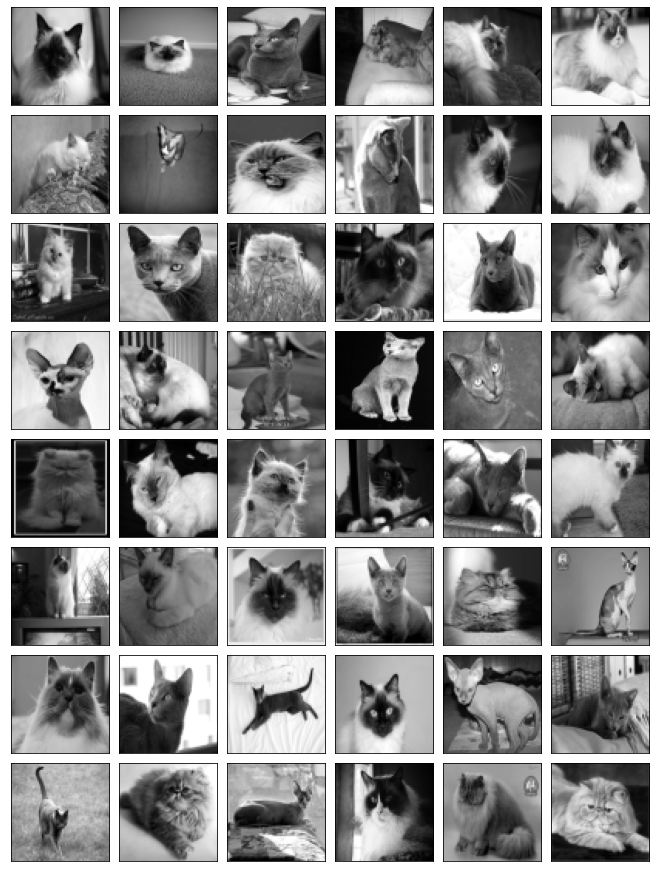


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



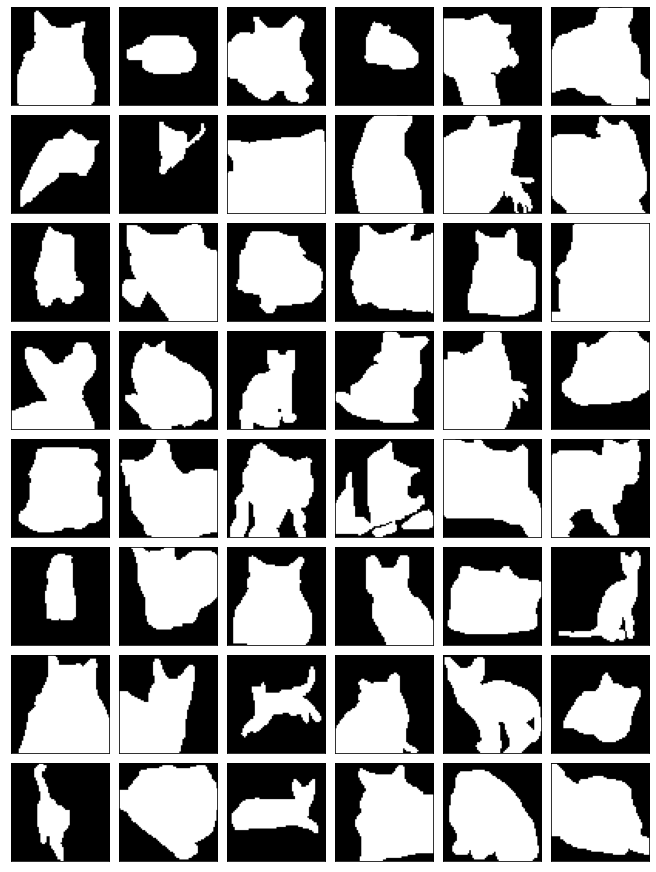


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



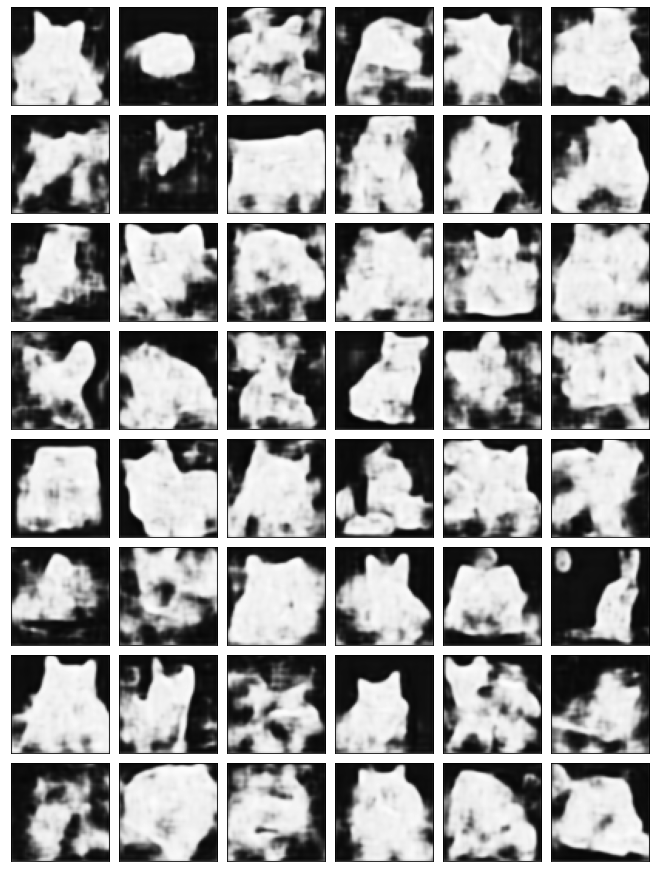


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



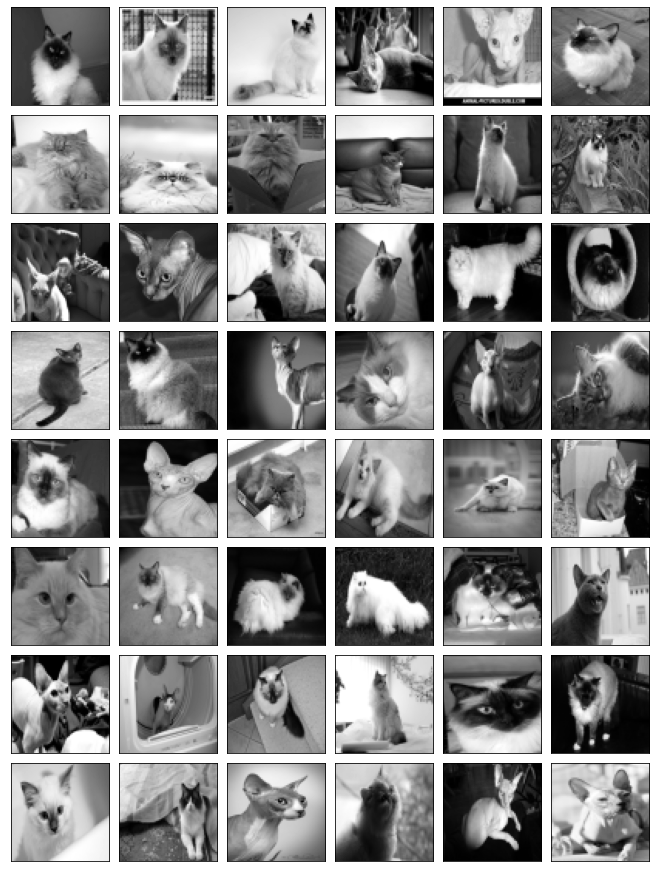


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



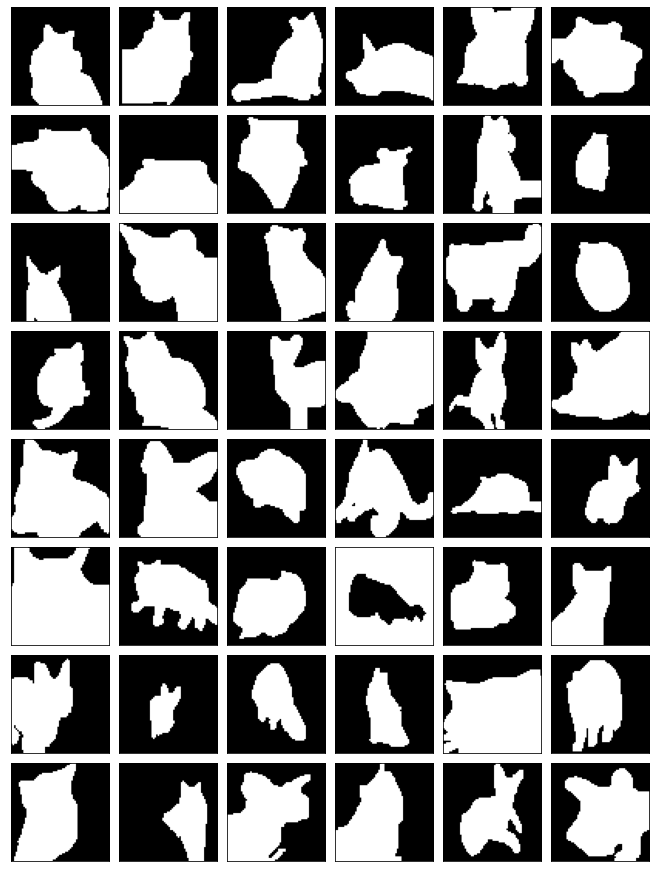


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



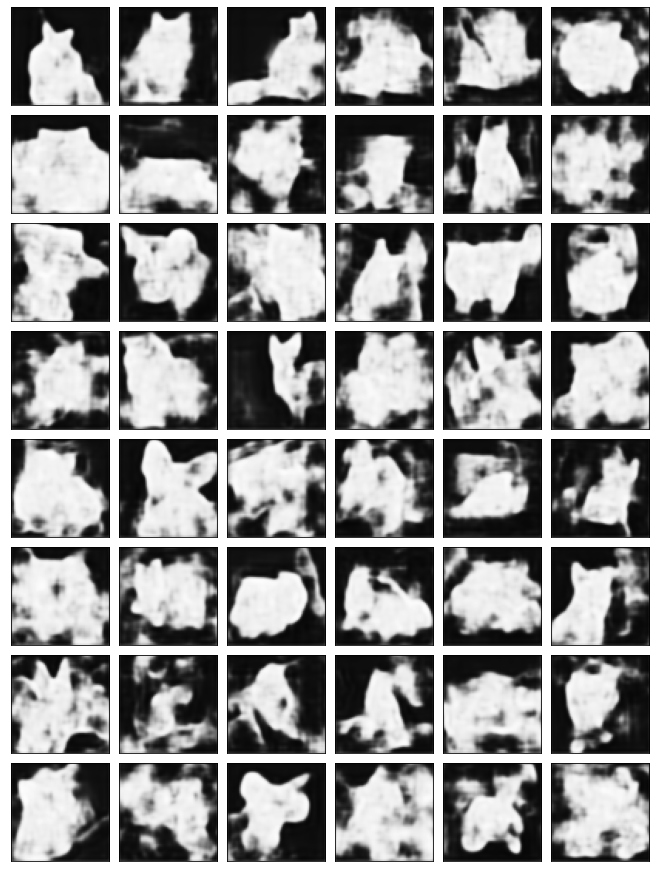


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



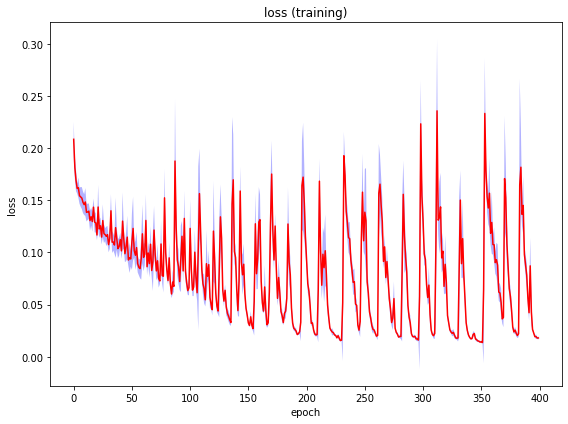


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



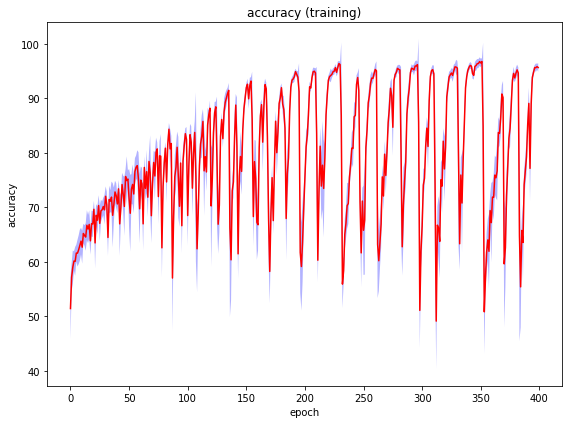


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



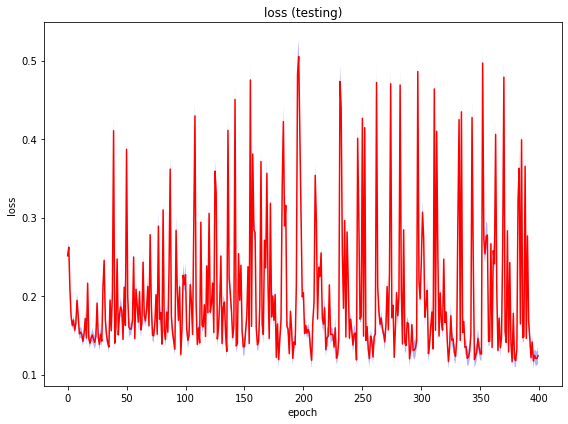


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



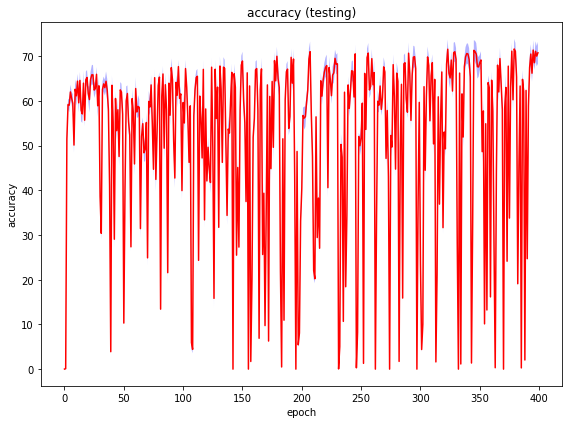


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0563833558
index =  1, value = 0.0422213109
index =  2, value = 0.0871599776
index =  3, value = 0.0430821570
index =  4, value = 0.0262540261
index =  5, value = 0.0228142740
index =  6, value = 0.0193150449
index =  7, value = 0.0193302009
index =  8, value = 0.0179482874
index =  9, value = 0.0180309530

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 85.0836462874
index =  1, value = 89.0636074871
index =  2, value = 77.1497198807
index =  3, value = 88.9828446771
index =  4, value = 93.8416554451
index =  5, value = 94.7476945430


In [40]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)